In [ ]:
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_files = glob.glob('/gdrive/MyDrive/DMML2Project/Umpire_Classification/Data/non_umpire/*.jpg')
j=0
IMG_DIM = (240, 240)
for img in train_files:
  j=j+1
  print(img)
  img = load_img(img,target_size=IMG_DIM)  # this is a PIL image
  x = img_to_array(img)  # this is a Numpy array with shape of image
  x= x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, shape of image)
  print(x.shape)

  # the .flow() command below generates batches of randomly transformed images
  # and saves the results to the `umpire and non_umpire` directory
  if (j == 0):
    i = 391
  count = 0
  for batch in datagen.flow(x, batch_size=1,save_to_dir='/gdrive/MyDrive/DMML2Project/Umpire_Classification/non_umpire', save_prefix='non_umpire'+str(i), save_format='jpeg'):
    i += 1
    count = count+1
    if count > 10:
      break  # otherwise the generator would loop indefinitely

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [ ]:
train_path = '/gdrive/MyDrive/DMML2Project/Umpire_Classification/Train/'
valid_path = '/gdrive/MyDrive/DMML2Project/Umpire_Classification/Test/'

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
folders = glob.glob('/gdrive/MyDrive/DMML2Project/Umpire_Classification/train/*')
temp0 = folders[0]
string0 = temp0.split("n/", 1)
substring0 = string0[1]
folders[0] = substring0
temp1 = folders[1]
string1 = temp1.split("n/", 1)
substring1 = string1[1]
folders[1] = substring1
folders = np.array(folders)
print(folders)

['umpire' 'non_umpire']


In [ ]:
#One_Hot Enconding of labels
le = LabelEncoder()
le.fit(folders)
folders_enc = le.transform(folders)
folders_one_hot_enc = OneHotEncoder(sparse=False)
folders_enc = folders_enc.reshape(len(folders_enc), 1)
folders_one_hot_enc = folders_one_hot_enc.fit_transform(folders_enc)
print(folders_one_hot_enc)

[[0. 1.]
 [1. 0.]]


In [ ]:
#Flattend and dropout layers added
x = Flatten()(vgg.output)
x = keras.layers.Dropout(0.2)(x) 
prediction = Dense(len(folders_enc), activation='softmax')(x)

In [ ]:
#Create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
#Structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#Model cost and optimization initalization 
optimizers = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizers,
  metrics=['accuracy']
)

In [ ]:
#dData Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/gdrive/MyDrive/DMML2Project/Umpire_Classification/Train/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/gdrive/MyDrive/DMML2Project/Umpire_Classification/Test/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 3432 images belonging to 2 classes.
Found 136 images belonging to 2 classes.


In [ ]:
#Fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=4,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
108/108 [==============================] - 1193s 11s/step - loss: 0.6081 - accuracy: 0.6685 - val_loss: 0.3531 - val_accuracy: 0.8750
Epoch 2/4
108/108 [==============================] - 1189s 11s/step - loss: 0.3425 - accuracy: 0.8502 - val_loss: 0.2708 - val_accuracy: 0.8824
Epoch 3/4
108/108 [==============================] - 1187s 11s/step - loss: 0.2422 - accuracy: 0.9144 - val_loss: 0.2410 - val_accuracy: 0.9044
Epoch 4/4
108/108 [==============================] - 1186s 11s/step - loss: 0.2011 - accuracy: 0.9337 - val_loss: 0.2136 - val_accuracy: 0.8971


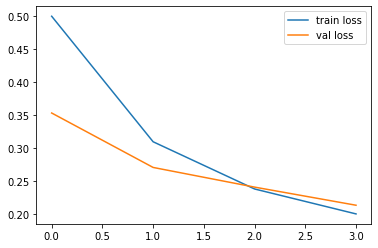

<Figure size 432x288 with 0 Axes>

In [ ]:
#Loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')